In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime as dt


import os
import plotly.graph_objects as go
import plotly.express as px
import pandas_ta as ta
import warnings

import xgboost
from google.colab import drive

from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split


drive.mount('/content/drive')
warnings.filterwarnings("ignore")

ModuleNotFoundError: ignored

## Data visualization of Nifty 

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NIFTY_DATA.csv", parse_dates= ["date"])
df["date"] = df["date"].apply(lambda x: x.date())
df.sort_index(ascending= False, inplace= True)

df["21_dma"]=df["close"].rolling(21).mean()
df["50_dma"]=df["close"].rolling(50).mean()
df = df.loc[df["date"] > dt(2020,1,1).date()]
df.reset_index(drop = True, inplace = True,)

In [ ]:
fig = px.line(df,x= 'date',y =['close','21_dma','50_dma'], labels= {"value": "Price","date":"Date"},title= "NIFTY Daily")

fig

### Adding some bunch of acessories to index without which looks incomplete

#### Data Normalization

As the proverb say "Pre-data analysis is as important as brushing teeth regularly" therfore normalizing the data aids the model and reduces the hard time. which improves our accuracy multiple folds by ensuring that different features take on value in similar ranges. 

#### Let's Normalize our daily index data to single normalized vector

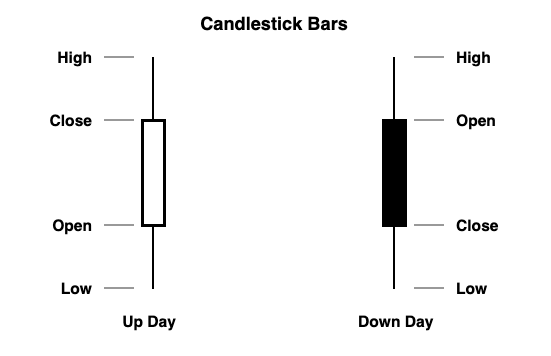

###### Given Above details we define 

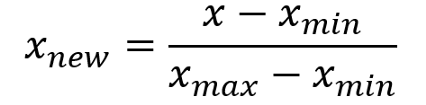

On adding this feature to dataframe we will get a frame like

In [ ]:
df["n_close"]= (df["close"] - df["low"]) / (df["high"] - df["low"])
# df["n_close"].max()

fig1 = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['close'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])
fig1.add_trace(go.Scatter(x= df.date, y = df["21_dma"],
                          name = '21 D Moving Average',
                          line = dict(color = 'blue')))
fig1.add_trace(go.Scatter(x= df.date, y = df["50_dma"],
                          name = '50 D Moving Average',
                          line = dict(color = 'black')))

NameError: ignored

In [ ]:
fig1.show()
fig_2 = px.imshow(df.corr())
fig_2.show()

NameError: ignored

## Applying Basic ML to Most Liquid Commodities on CBOT

In [ ]:
df_l = []  # list of Dataframes
l = os.listdir("/content/drive/MyDrive/Colab Notebooks/aeiou")
for i in l:
    if ".csv" in i :
        
        sd_temp = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/aeiou/{i}", parse_dates= ["Date"])
        sd_temp["Date"] = sd_temp["Date"].apply(lambda x: x.date())   # Parsing Dates to date time format 
        sd_temp["Month"] = sd_temp["Date"].apply(lambda x: x.month)   # Month number
        sup_trend= ta.supertrend(sd_temp["High"],sd_temp["Low"],sd_temp["Close"],length= 10,multiplier=2)["SUPERT_10_2.0"]
        sd_temp["Super_trend"] = sup_trend                            # Adding supertrend indicator to data
        atr = ta.atr(sd_temp["High"],sd_temp["Low"],sd_temp["Close"],length= 14)
        sd_temp["Atr"] = atr                                          # Average true range of closing prices
        
        #Adding Moving averages as vectors
        sma_21=ta.sma(sd_temp["Close"],length=21)                     
        sd_temp["21_SMA"] =sma_21
        sma_50=ta.sma(sd_temp["Close"],length=50)
        sd_temp["50_SMA"] =sma_50
        sma_100=ta.sma(sd_temp["Close"],length=100)
        sd_temp["100_SMA"] =sma_100
        
        #Donchain Bands 
        dc_u_20=ta.donchian(sd_temp["High"],sd_temp["Low"],lower_length=20,upper_length=20)["DCU_20_20"]
        dc_l_20=ta.donchian(sd_temp["High"],sd_temp["Low"],lower_length=20,upper_length=20)["DCL_20_20"]
        sd_temp["Lower_donchian"]= dc_l_20
        sd_temp["Upper_donchian"]= dc_u_20
        rsi = ta.rsi(sd_temp["Close"])
        sd_temp["RSI"]= rsi
        
        #Normalizing 
        
        sd_temp["norm_candle"]= (sd_temp["Close"] -sd_temp["Low"]) / (sd_temp["High"]- sd_temp["Low"]) 
        sd_temp["Buy/Sell"] = np.nan

        
        #Target variable  (More in below Markdown ::)
        
        for i in range(len(sd_temp)-3):
            cf = sd_temp["Close"][i+3]
            if cf > sd_temp["Close"][i]:
                sd_temp["Buy/Sell"][i]= 1
            else:
                sd_temp["Buy/Sell"][i]= 0
        
        
        
        sd_temp=sd_temp.loc[sd_temp["Date"] > dt(2018,1,1).date()]
        sd_temp.dropna(inplace = True)
        
        sd_temp.reset_index(drop= True, inplace = True)
#         print(sd_temp.head())
        df_l.append(
        sd_temp
    )

### :: Target variable 

###### Target variable is feature of data frame we are trying to predict.

 In our case we are predicting Buy as 1 and 0 as Sell and exiting and every 3rd The main logic behind this 3 day figure comes from common saying "Time in market beats timing in market"  but also we can't take value large enough. In core markets are just rewarding the premia of extra risk we are exposed while holding our positions for longer time. 

###### In the below cell we are only adding suitable tickers 

In [ ]:
fl = []
for i in df_l:
    if i["Volume"][0] != 0:
        fl.append(i)
    fd= {}
fd["corn"]= fl[0]
fd["crudeoil"]= fl[1]
fd["wheat"]= fl[2]
fd["SPX"] = fl [4]

#### Correlation Matrix 

In [ ]:
zf =df_l[0]
for i in df_l:
    zf = pd.merge(zf,i, on = "Date")
zf=zf[["Adj Close_x","Adj Close_y"]]
zf.columns = ["CORN","CRUDEOIL","EUR","WHEAT","WHEAT","CORN","DXY","SOYBEANS","SPX","YEN"]
px.imshow(zf.corr())

The accuracy score is as follows:

In [ ]:
asd= {}
cd= {}
for co_name, co_df in fd.items():
    X= co_df.loc[:,['Month', 'Adj Close', 'Volume','Super_trend', 'Atr', '21_SMA', '50_SMA','100_SMA','Lower_donchian','Upper_donchian', 'RSI', 'norm_candle']]
    y=co_df.loc[:,'Buy/Sell']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#     X_train

    xgb = xgboost.XGBClassifier(eval_metric = 'logloss' )
    xgb.fit(X_train,y_train)
    preds = xgb.predict(X_test)
    
    asd[co_name]= accuracy_score(y_test,preds)
    print(f"Accuracy Score for {co_name} is {accuracy_score(y_test,preds)} and report is \n {classification_report(y_test,preds)}")
    cd[co_name]=confusion_matrix(y_test,preds)

Accuracy Score for corn is 0.6712962962962963 and report 
               precision    recall  f1-score   support

         0.0       0.61      0.62      0.61        91
         1.0       0.72      0.71      0.71       125

    accuracy                           0.67       216
   macro avg       0.66      0.66      0.66       216
weighted avg       0.67      0.67      0.67       216

Accuracy Score for crudeoil is 0.6084905660377359 and report 
               precision    recall  f1-score   support

         0.0       0.59      0.66      0.62       104
         1.0       0.63      0.56      0.59       108

    accuracy                           0.61       212
   macro avg       0.61      0.61      0.61       212
weighted avg       0.61      0.61      0.61       212

Accuracy Score for wheat is 0.7037037037037037 and report 
               precision    recall  f1-score   support

         0.0       0.69      0.43      0.53        84
         1.0       0.71      0.88      0.78       132



In [ ]:
def plt_confusion_matrix(cdty):
    conf_matrix = cd[cdty]
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.BuPu, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

We can plot confusion matrix of any of listed commodities


*   SPX
*   corn
*   crudeoil
*   wheat

Example given below





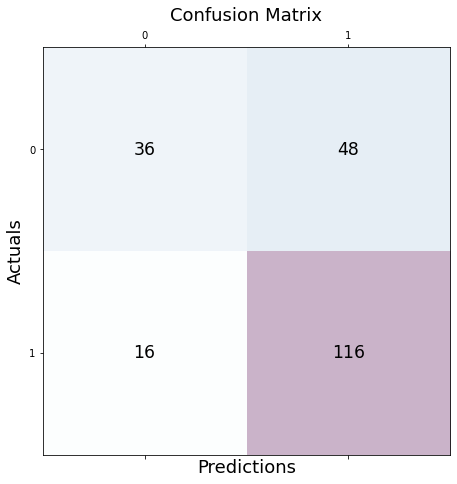

In [ ]:
plt_confusion_matrix('wheat')

# End